## CrossMAE Visualization Demo

This is a visualization demo using our pre-trained CrossMAE models. The code is adapted from the original MAE visualization demo: https://github.com/facebookresearch/mae/blob/main/demo/mae_visualize.ipynb

### Prepare


In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import sys
import requests

import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

sys.path.append('..')
import models_cross

/home/mfu/miniconda3/envs/mae1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


def unnormalize(x):
    # x is [H, W, 3]
    assert x.shape[-1] == 3
    return torch.clip((x * imagenet_std + imagenet_mean) * 255, 0, 255).int()


def show_image(image, title=''):
    # image is [H, W, 3]
    if image.dtype != torch.int:
        image = unnormalize(image)
    plt.imshow(image)
    # assert image.shape[2] == 3
    # plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def calculate_psnr(orig, pred, mask=None):
    if mask is not None:
        # only calculate mse on the mask 
        se = (orig - pred) ** 2
        mse = torch.sum(se * mask) / torch.sum(mask)
    else:
        se = (orig - pred) ** 2
        mse = se.float().mean()
    if (mse == 0):
        return 100
    return 20 * torch.log10(255. / torch.sqrt(mse))

def prepare_model(chkpt_dir, arch='mae_vit_base_patch16', decoder_depth=12, weight_fm=True, use_input=True):
    # build model
    model = getattr(models_cross, arch)(
        decoder_depth=decoder_depth,
        weight_fm=weight_fm,
        use_input=use_input,
    )
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model, norm_pix_loss=False):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    if norm_pix_loss:
        target = model.patchify(x)
        mean = target.mean(dim=-1, keepdim=True)
        var = target.var(dim=-1, keepdim=True)

    # run MAE
    loss, y_pred, y_target, mask = model(x.float(), mask_ratio=0.75, kept_mask_ratio=0.75, vis=True)
    y = y_pred
    print("loss: ", loss)

    if norm_pix_loss:
        y = y * (var + 1.e-6)**.5 + mean
    
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    print("Mask min, max: ", mask.min(), mask.max())

    x = torch.einsum('nchw->nhwc', x)

    # calculate psnr 
    print("PSNR on masked patches: ", calculate_psnr(unnormalize(x), unnormalize(y), mask))

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")
    print("PSNR on model pred: ", calculate_psnr(unnormalize(x), unnormalize(y)))

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    print("PSNR on combined patches: ", calculate_psnr(unnormalize(x), unnormalize(im_paste)))

    plt.show()

### Load an image

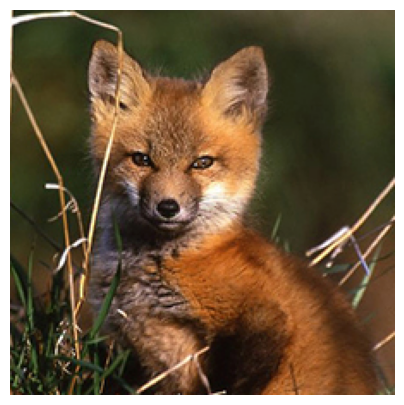

In [3]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
# img = Image.open("n02509815_9988.JPEG")
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained CrossMAE model

In [4]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://huggingface.co/longlian/CrossMAE/resolve/main/vitb-mr0.75-kmr0.75-dd12/imagenet-mae-cross-vitb-pretrain-wfm-mr0.75-kmr0.75-dd12-ep800-ui.pth
chkpt_dir = 'imagenet-mae-cross-vitb-pretrain-wfm-mr0.75-kmr0.75-dd12-ep800-ui.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16', weight_fm=True, use_input=True)
print('Model loaded.')


use self attention:  False
<All keys matched successfully>
Model loaded.


### Run CrossMAE on the image

CrossMAE with pixel reconstruction:
loss:  tensor(1.2796, grad_fn=<MeanBackward0>)
Mask min, max:  tensor(0.) tensor(1.)
PSNR on masked patches:  tensor(19.9616)
PSNR on model pred:  tensor(19.0736)
PSNR on combined patches:  tensor(21.2110)


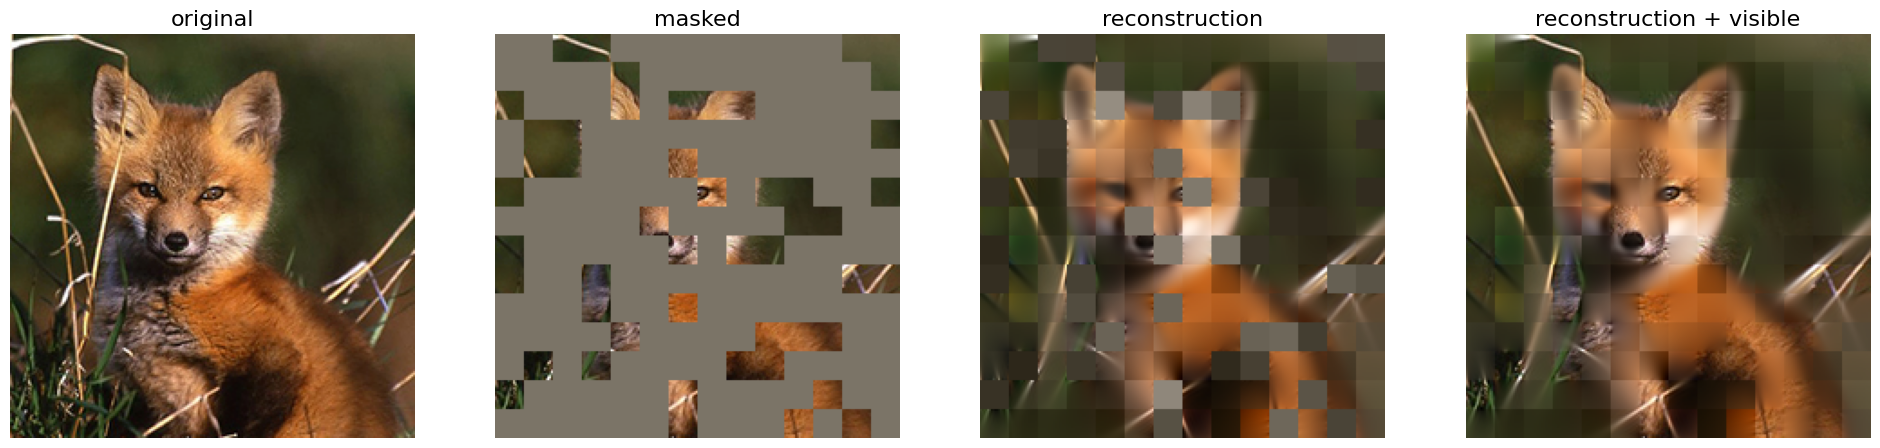

In [5]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(0)
print('CrossMAE with pixel reconstruction:')
run_one_image(img, model_mae, norm_pix_loss=True)